In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import getpass
import sys
sys.path.insert(0, f'/home/{getpass.getuser()}/dowgan/dowgan')
import Util

In [2]:
# Set device to GPU for faster processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# CSV path
folder_name = "data"
file_name = "hungary_chickenpox.csv"
path = os.path.join('../',folder_name, file_name)
#Load CSV into Dataframe
df = pd.read_csv(path,sep=',')
df = df.drop(columns = ['Date'])

In [4]:
df

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
1,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
3,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
4,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,95,12,41,6,39,0,16,15,14,10,56,7,13,122,4,23,4,11,110,10
518,43,39,31,10,34,3,2,30,25,19,34,20,18,70,36,5,23,22,63,9
519,35,7,15,0,0,0,7,7,4,2,30,36,4,72,5,21,14,0,17,10
520,30,23,8,0,11,4,1,9,10,17,27,17,21,12,5,17,1,1,83,2


In [5]:
# Specify length of test data, Takes first ## from csv
num_data = 200
df_test = df.iloc[:num_data]

In [6]:
# Input size and output size specify the shape of the tensor fed into the NN
input_size = len(df.columns)
output_size= len(df.columns)
# Hidden Layers and num Layers specify the size of the NN num_layers is arbitrary
hidden_size = len(df.columns)
num_layers = 10
# batch size is the size of data used in training
batch_size = 20
# Learning rate is the step size in optimizer
lr_g=0.00001
lr_d=0.00001
# Number of epochs  is the number of training cycles
num_epochs = 20

In [7]:
# Convert data to numpy
data = df_test.to_numpy()

# Convert numpy array to PyTorch tensor
tensor = torch.tensor(data, dtype=torch.float32)

# Create TimeSeriesDataset object
dataset = TensorDataset(tensor)

# Create DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float)

In [9]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.leakyrelu = nn.LeakyReLU()
        
    def forward(self, x):
        with torch.backends.cudnn.flags(enabled=False):
            x, _ = self.rnn(x)
            x = self.dropout(x)
            x = self.fc1(x)
            x = self.leakyrelu(x)
            x = self.dropout(x)
            x = self.fc1(x)
            x = self.leakyrelu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.leakyrelu(x)
            x = self.dropout(x)
            return x

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
        self.leakyrelu = nn.LeakyReLU()
        
    def forward(self, x):
        with torch.backends.cudnn.flags(enabled=False):
            x, _ = self.rnn(x)
            x = self.fc(x)
            x = self.leakyrelu(x)
            x = self.dropout(x)
            x = self.sigmoid(x)
            return x.squeeze()

In [11]:
def train_gan(generator, discriminator, dataloader, batch_size,input_size, num_epochs, lr_g=0.001, lr_d=0.001, critic_iters=5):
    
    # Set the GEN and DIS to GPU for Faster computing
    generator.to(device)
    discriminator.to(device)
    # Define Optimizer used for training
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

    # This is the main traiining loop
    for epoch in range(num_epochs):
        for i, real_samples in enumerate(dataloader):
            # Load real samples through data loader
            real_samples = torch.stack(real_samples, dim=0).to(device)

            # Train discriminator
            for critic_iter in range(critic_iters):
                #This loop trains the discriminator using the Wasserstien loss
                # Critic iter is the number of iterations the discriminator goes through for each loop of the generator
                noise = torch.randn(batch_size, 1, input_size, device=device)
                fake_samples = generator(noise).detach()
                real_output = discriminator(real_samples)
                fake_output = discriminator(fake_samples)

                # Calculate Wasserstein loss
                loss_d = -torch.mean(real_output) + torch.mean(fake_output)

                # Gradient penalty
                alpha = torch.rand(batch_size, 1, device=device)
                interpolated = alpha * real_samples + (1 - alpha) * fake_samples
                interpolated.requires_grad = True
                interpolated_output = discriminator(interpolated)
                gradients = torch.autograd.grad(outputs=interpolated_output, inputs=interpolated,
                                                grad_outputs=torch.ones_like(interpolated_output),
                                                create_graph=True, retain_graph=True)[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                loss_d += 10 * gradient_penalty
                # Back propagate the training weights and bias
                optimizer_d.zero_grad()
                loss_d.backward()
                optimizer_d.step()

            # Train generator
            noise = torch.randn(batch_size, 1, input_size, device=device)
            fake_samples = generator(noise)
            fake_output = discriminator(fake_samples)
            loss_g = -torch.mean(fake_output)
            # Back propagate the training weights and bias
            optimizer_g.zero_grad()
            loss_g.backward()
            optimizer_g.step()

            if i % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} | Discriminator Loss: {loss_d.item():.4f} | Generator Loss: {loss_g.item():.4f}")

In [12]:
# Define generator and discriminator
generator = Generator(input_size,output_size, hidden_size, num_layers)
discriminator = Discriminator(input_size, hidden_size, num_layers)

In [13]:
# Train the WGAN
train_gan(generator, discriminator, dataloader,batch_size,input_size, num_epochs, lr_g, lr_d)

Epoch 1/20 | Discriminator Loss: 9.9904 | Generator Loss: -0.4999
Epoch 2/20 | Discriminator Loss: 9.9864 | Generator Loss: -0.4999
Epoch 3/20 | Discriminator Loss: 9.9784 | Generator Loss: -0.4999
Epoch 4/20 | Discriminator Loss: 9.9743 | Generator Loss: -0.4999
Epoch 5/20 | Discriminator Loss: 9.9700 | Generator Loss: -0.4999
Epoch 6/20 | Discriminator Loss: 9.9609 | Generator Loss: -0.4999
Epoch 7/20 | Discriminator Loss: 9.9485 | Generator Loss: -0.4999
Epoch 8/20 | Discriminator Loss: 9.9454 | Generator Loss: -0.5000
Epoch 9/20 | Discriminator Loss: 9.9336 | Generator Loss: -0.5000
Epoch 10/20 | Discriminator Loss: 9.9206 | Generator Loss: -0.5000
Epoch 11/20 | Discriminator Loss: 9.9076 | Generator Loss: -0.5000
Epoch 12/20 | Discriminator Loss: 9.8772 | Generator Loss: -0.5000
Epoch 13/20 | Discriminator Loss: 9.8908 | Generator Loss: -0.5000
Epoch 14/20 | Discriminator Loss: 9.8264 | Generator Loss: -0.5000
Epoch 15/20 | Discriminator Loss: 9.7528 | Generator Loss: -0.5001
Epoc

In [14]:
# Generate the new data, size is the number of time points
z = torch.randn(size=(500, input_size), device=device)
with torch.no_grad():
    fake_samples = generator(z)

In [15]:
# Get column names
names = Util.get_column_names(df)

In [16]:
# Convert tensor to CPU
fake_samples = fake_samples.cpu().numpy()

In [17]:
# This is what the Generated time series looks like
df_gen = pd.DataFrame(fake_samples)
df_gen = df_gen.set_axis(names, axis=1, inplace=False)
df_gen


,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,0.178385,-0.001458,0.018072,0.055130,0.263349,-0.002265,-0.000744,-0.002749,0.119954,0.139794,-0.000000,0.023490,0.227107,0.085919,-0.001587,0.253248,0.047601,0.190090,0.000000,-0.001699
1,0.220638,-0.001662,-0.000155,0.035728,0.260139,-0.001535,-0.000984,-0.003175,0.173315,0.183533,-0.001820,0.032391,0.253610,0.014080,-0.000000,0.173554,-0.000156,0.200028,0.221792,-0.002203
2,0.199795,-0.001647,-0.000449,0.029192,0.268001,-0.001446,-0.001245,-0.003321,0.157595,0.209926,-0.001984,0.005717,0.000000,0.002323,-0.001623,0.000000,-0.000047,0.171263,0.242722,-0.002403
3,0.000000,-0.001766,-0.000725,0.000000,0.239093,-0.001083,-0.001080,-0.003472,0.159313,0.220908,-0.000000,0.000000,0.279383,-0.000011,-0.001617,0.000000,0.001163,0.186058,0.239337,-0.002475
4,0.236836,-0.001695,-0.000272,0.028022,0.254838,-0.001402,-0.001102,-0.003202,0.177037,0.194979,-0.001814,0.000000,0.270354,0.000000,-0.001936,0.000000,-0.000272,0.210740,0.233135,-0.002149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.224547,-0.001755,-0.000589,0.050395,0.305471,-0.000000,-0.001622,-0.003642,0.119345,0.215411,-0.001697,0.000000,0.256041,0.012671,-0.001664,0.184007,-0.000500,0.212040,0.000000,-0.001822
496,0.200169,-0.001706,-0.000364,0.069861,0.296013,-0.000000,-0.001110,-0.002789,0.061842,0.147424,-0.000000,0.042328,0.221935,0.113970,-0.001356,0.245803,0.025802,0.000000,0.169877,-0.001176
497,0.236716,-0.001735,-0.000141,0.023767,0.258451,-0.001293,-0.000882,-0.003265,0.187238,0.194210,-0.001809,0.000000,0.266797,0.000000,-0.002074,0.160398,-0.000282,0.212395,0.223229,-0.002253
498,0.238873,-0.001805,-0.000385,0.015167,0.248129,-0.000000,-0.001097,-0.003325,0.000000,0.212670,-0.001717,0.041464,0.000000,0.005174,-0.001988,0.163164,-0.000282,0.207334,0.227880,-0.002169


Text(0.5, 0, 'Time')

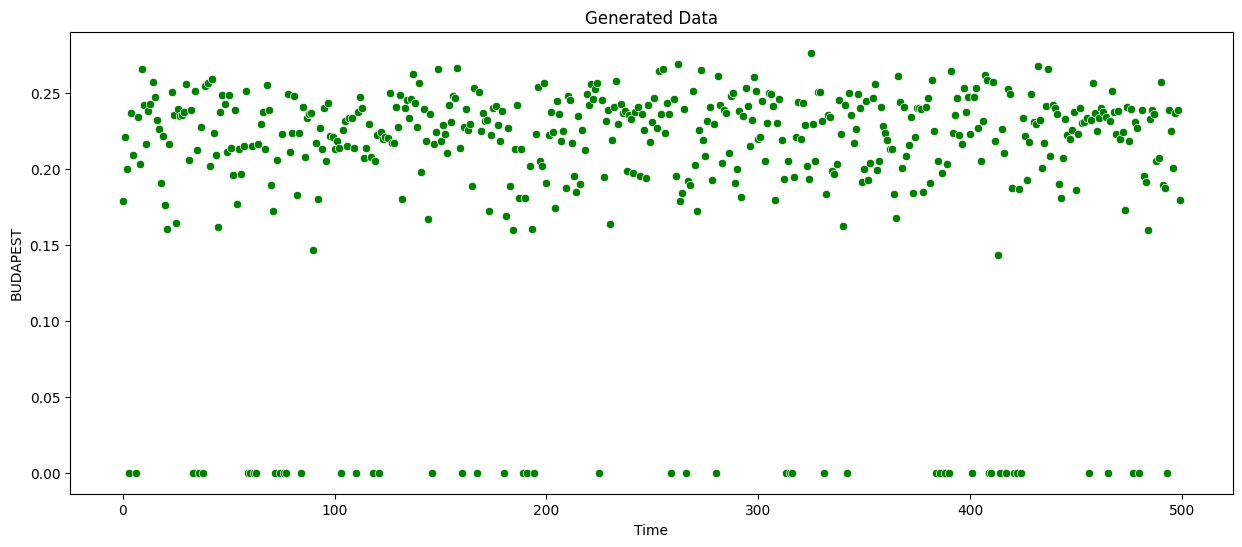

In [18]:
# Plot the generated data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_gen,x=df_gen.index, y=df_gen[names[0]], color='g')
axes.set_title('Generated Data')
axes.set_xlabel("Time")

Text(0.5, 0, 'Time')

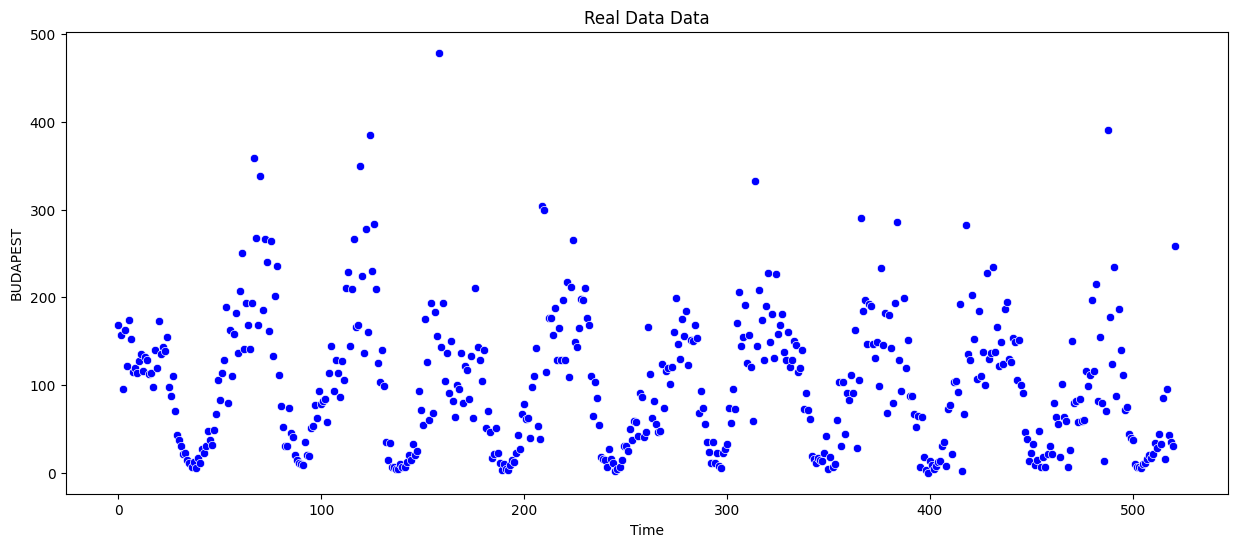

In [19]:
# This is what the real data time series looks like

fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df,x=df.index, y=df[names[0]], color='b')
axes.set_title('Real Data Data')
axes.set_xlabel("Time")

Text(0.5, 1.0, 'Real vs Generated Data')

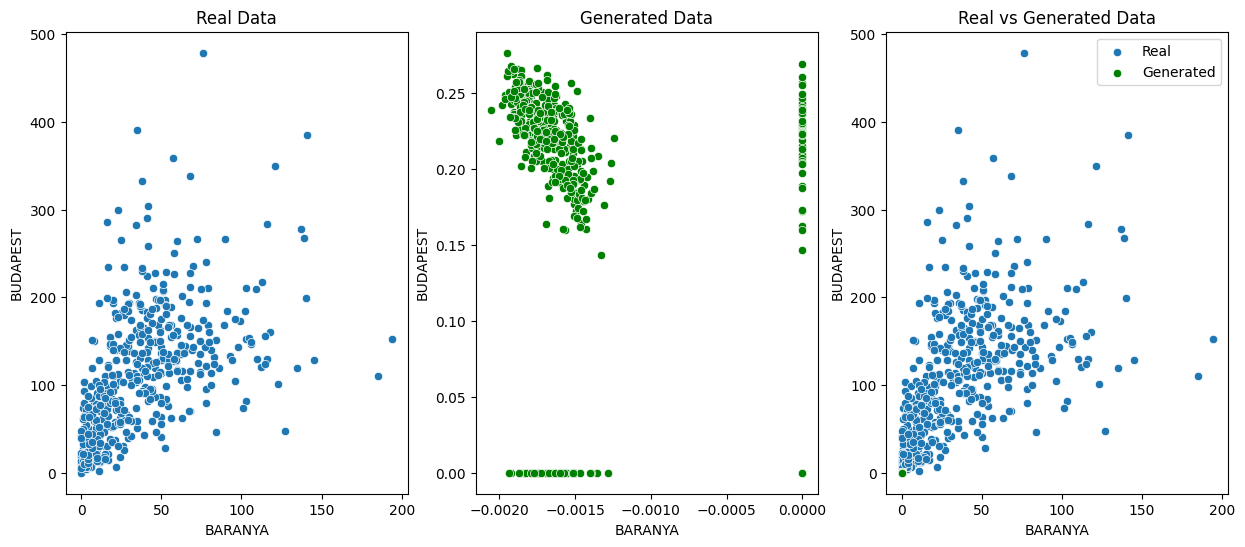

In [20]:
# Plotting Real vs Generated data
fig, axes = plt.subplots(1, 3, figsize=(15, 6))


sns.scatterplot(ax=axes[0],x=names[1], y=names[0], data=df)
axes[0].set_title('Real Data')

sns.scatterplot(ax=axes[1], data=df_gen,x=names[1], y=df_gen[names[0]], color='g')
axes[1].set_title('Generated Data')

sns.scatterplot(ax=axes[2], data=df, x=names[1], y=names[0], label='Real')
sns.scatterplot(ax=axes[2], data=df_gen, x=names[1], y=names[0], color='g', label= 'Generated')
axes[2].set_title('Real vs Generated Data')
